Oracle Data Science service sample notebook.

Copyright (c) 2022, 2023 Oracle, Inc. All rights reserved. Licensed under the [Universal Permissive License v 1.0](https://oss.oracle.com/licenses/upl).

---

# <font color="red">Graph Analytics and Graph Machine Learning with PyPGX</font>
<p style="margin-left:10%; margin-right:10%;">by the <font color="teal">Oracle Cloud Infrastructure Data Science Service.</font></p>

---

# Overview:

Graph analysis lets you reveal latent information that is not directly apparent from fields in your data, but is encoded as direct and indirect relationships between elements of your data. This connectivity-related information is not obvious to the naked eye, but can have tremendous value after it is uncovered. Parallel Graph AnalytiX (PGX) is a toolkit for graph analysis and supports both efficient graph algorithms and fast SQL-like graph pattern matching queries.

The tools included as part of the PGX distribution include the PGX Algorithms. PGX is a domain-specific language for writing graph analysis algorithms in a simple and readable form, which the PyPGX runtime can transparently optimize and run. This notebook explores the built-in algorithms provided by PyPGX.

PyPGX provides a machine learning library that supports the following (graph-empowered) machine learning algorithms:
* [DeepWalk](https://docs.oracle.com/cd/F41824_01/latest/prog-guides/mllib/deepwalk.html) (Vertex embeddings)
* [SupervisedGraphWise](https://docs.oracle.com/cd/F41824_01/latest/prog-guides/mllib/supervisedgraphwise.html) (Vertex embeddings and classification)
* [UnsupervisedGraphWise](https://docs.oracle.com/cd/F41824_01/latest/prog-guides/mllib/unsupervisedgraphwise.html) (Vertex embeddings)
* [Pg2vec](https://docs.oracle.com/cd/F41824_01/latest/prog-guides/mllib/pg2vec.html) (Graph embeddings)

[Property Graph Query Language (PGQL)](https://pgql-lang.org/spec/latest/) is an SQL-based query language for the property graph data model that allows you to specify high-level graph patterns that are matched against vertices and edges in a graph. PGQL has support for grouping (GROUP BY), aggregation (`MIN`, `MAX`, `AVG`, `SUM`), sorting (`ORDER BY`), and many other familiar SQL constructs. Furthermore, PGQL has powerful regular expression constructs for graph reachability (transitive closure), shortest path finding, and cheapest path finding.

In this notebook, you use the scikit-learn diabetes dataset to build:
1. a graph to demonstrate several graph algorthms,
2. graph machine learning models, and
3. a graph to demonstrate PGQL.

---
    
## Contents:

* <a href="#intro"><b>Introduction</b></a>
    * <a href="#intro_session_analyst">Session and Analyst Objects</a>
    * <a href="#intro_dataset">Dataset</a>
* <a href="#create_graph"><b>Create a Graph</b></a>
    * <a href="#create_graph_nodes">Create Nodes</a>
    * <a href="#create_graph_edge">Create Edges</a>
    * <a href="#create_graph_save">Save Graph Data</a>
    * <a href="#create_graph_load">Load Graph Data</a>
* <a href='#built-in'><b>PyPGX's Built-in Algorithms</b></a>
    * <a href='#built-in_pagerank'>Personnalized PageRank</a>
    * <a href='#built-in_eigenvector'>Eigenvector Centrality</a>
    * <a href='#built-in_diameter'>Diameter / Radius</a>
    * <a href='#built-in_lcc'>Local Clustering Coefficient</a>
    * <a href='#built-in_label'>Communities Label Propagation</a>
* <a href="#example"><b>Graph Machine Learning Examples</b></a>
    * <a href='#example_pagerank'>Example: Personalize PageRank</a>
    * <a href='#example_deepwalk'>Example: DeepWalk</a>
* <a href='#pgql'><b>PGQL Queries</b></a>
    * <a href='#pgql_patients'>Example: Filter Patients Based On Age</a>
    * <a href='#pgql_bmi'>Example: Patients with a High BMI</a>
* <a href="#ref"><b>References</b></a>

---

**Important:**

Placeholder text for required values are surrounded by angle brackets that must be removed when adding the indicated content. For example, when adding a database name to `database_name = "<database_name>"` would become `database_name = "production"`.

---

Datasets are provided as a convenience.  Datasets are considered third-party content and are not considered materials 
under your agreement with Oracle.
     
You can access the `diabetes` dataset license [here](https://opensource.org/licenses/BSD-3-Clause).

---
The notebook is compatible with the following [Data Science conda environment](https://docs.oracle.com/en-us/iaas/data-science/using/conda_environ_list.htm):

* [Parallel Graph AnalytiX 23.1 and Oracle Property Graph 23.1 for CPU on Python 3.8 (version 1.0)](oci://service-conda-packs@id19sfcrra6z/service_pack/cpu/Parallel_Graph_AnalytiX_23.1_and_Oracle_Property_Graph_23.1_for_CPU_on_Python_3.8/1.0/pypgx2310_p38_cpu_v1)


In [1]:
import logging
logging.basicConfig(level=logging.ERROR)
import warnings
warnings.filterwarnings('ignore')

import json
import numpy as np
import os
import pandas as pd
import pypgx
import seaborn as sns
import sklearn
import shutil
import tempfile

from ads.common.model import ADSModel
from ads.dataset.dataset_browser import DatasetBrowser
from ads.dataset.factory import DatasetFactory
from ads.evaluations.evaluator import ADSEvaluator
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/home/datascience/conda/pypgx2310_p38_cpu_v1/lib/python3.8/site-packages/pypgx/jars/log4j-slf4j-impl-2.17.1.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/home/datascience/conda/pypgx2310_p38_cpu_v1/lib/python3.8/site-packages/opg4py/jars/logback-classic-1.2.10.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.apache.logging.slf4j.Log4jLoggerFactory]


<a id="intro"></a>
# Introduction

Graphs are a powerful abstraction that enable knowledge discovery by revealing the relationships between entities. Graphs consist of a set of entities, which are represented as vertices (also called nodes). The relationships between vertices are connected by a collection of edges (also called connectors). Graph analytics strive to reveal the latent or hidden information within these relationships. The information in a graph encodes not just the direct relationships, but the indirect relationships between entities as well. While humans are good at determining connections between entities, it's not practical to do this at the scale and level of detail that is common in modern graphs because the datasets tend to be large and heterogeneous.

<!-- Graph analytic algorithms have been developed to merge the properties of graphs with deep neural networks. In this approach, the graph is a representation of learning that employs neural embeddings using vertices and edges as learning units. This representation enables graphs to learn low-dimensional vector representations in an unsupervised and task agnostic manner. This approach has been used in applications such a link prediction and friendship recommendation engines in social networks.

The [Parallel Graph AnalytiX (PGX)](https://www.oracle.com/middleware/technologies/parallel-graph-analytix.html) library provides access to powerful graph analytics functionality. It supports a broad spectrum of analytics capabilities such as Graph Machine Learning (for example, DeepWalk, [GraphSAGE](http://snap.stanford.edu/graphsage/), Deep Graph Infomax, and many more). PGX has more than 60 built-in graph algorithms such as [PageRank](https://en.wikipedia.org/wiki/PageRank), InfoMap, Centrality, and others.

Computational performance is baked into PGX as its algorithms are optimized and parallelized. It is written in Java and has Python bindings in the PyPGX product. -->

<a id="intro_session_analyst"></a>
## Session and Analyst Objects

To access the graph analytic functionalities, you need an [analyst](https://docs.oracle.com/cd/F41824_01/latest/api/api.html#pypgx.api.Analyst) object as the entry point to all the graph analytics capabilities. PyPGX is [session](https://docs.oracle.com/cd/F41824_01/latest/api/api.html#pypgx.api.ServerInstance.get_session)-based and the method `pypgx.get_session()` returns a session object. An analyst object is obtained by calling `.analyst` on the session object.

In [2]:
# pypgx variables
session = pypgx.get_session()
analyst = session.analyst

<a id="intro_dataset"></a>
## Dataset

The SciKit-learn [diabetes dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset) has 442 observations and eleven metrics. This notebook uses the age and BMI metrics. The data has been preprocessed so that it is centered and scaled. 

The next cell reverts this preprocessing so that the original raw data is recovered. However, an additional transformation is made so that the values are converted to natural numbers. This conversion is explained in more detail when the [bipartite graph](https://en.wikipedia.org/wiki/Bipartite_graph) is constructed.

In [3]:
df = DatasetBrowser.sklearn().open("diabetes").to_pandas_dataframe()

# reverse transforming the variables for use in the bipartite graph
df['age'] = df['age'].apply(lambda x: int(275.29 * x + 48.52))
df['bmi'] = df['bmi'].apply(lambda x: int(92.78 * x + 26.375))
df['sex'] = df['sex'].apply(lambda x: int(10.49 * x + 1.468))

loop1:   0%|          | 0/4 [00:00<?, ?it/s]

<a id="create_graph"></a>
# Create a Graph

With this data, there's no obvious graph structure to it. However, you could construct a bipartite graph to impose a graph structure onto the data. A [bipartite graph](https://en.wikipedia.org/wiki/Bipartite_graph) is a graph where the vertices are split into two separate sets. Each edge in the graph goes from one set to the other set so there aren't edges that connect vertices in the same set. In this model, the patient information is placed in the left set of vertices. The right set of vertices contain all of the possible values for each feature.

The following figure presents a representation of this graph showing the relationship between the patient, age, and BMI. Notice that on the left each vertex represents a patient and all data associated with that patient. The vertices on the right contain one feature and a possible value. All possible features and values are represented by a vertex.

Features such as age and BMI are continuous, and it isn't possible to make a vertex for all possible values. Therefore, the vertices in the right set are treated as discrete values, but the edges between the two sets connect to adjacent values. You can see this in the graph where the data for Patient i has connections to BMI=16, BMI=17, and BMI=18 because the recorded BMI is 17 (BMI=16 and BMI=18 are the adjacent values of BMI=17). This procedure of creating edges is repeated for each feature. Notice that the edges for Patient i connects to Age=20, Age=21, and Age=22 because the stated age is 21 and 20 and 22 are adjacent values. This captures the continuous nature of BMI, Age, and the other features.

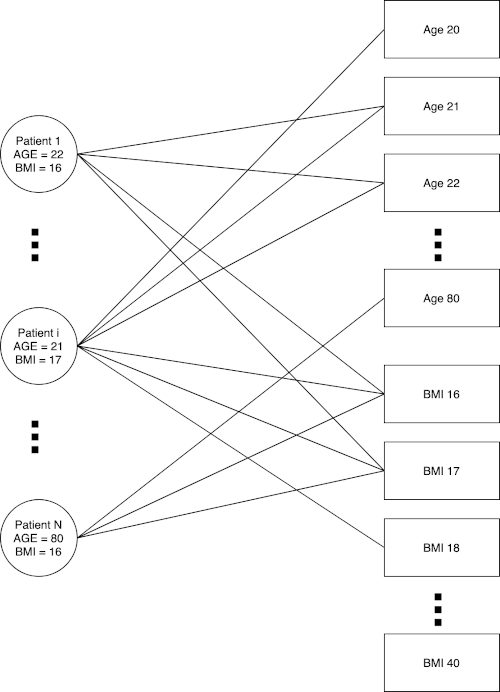

<a id="create_graph_nodes"></a>
## Create Nodes

Each node is represented as an integer so it is possible to determine the number of nodes that are needed. One node is required for each patient. For the age and BMI metrics, there is a single node for each integer value in the range of observed values in the data.

In [4]:
n_patients = len(df)
n_age = np.ptp(df['age']) + 1
n_bmi = np.ptp(df['bmi']) + 1
n_total = n_patients + n_age + n_bmi

print('Number of patient nodes   : %3d' % n_patients)
print('Number nodes for age : %3d' % n_age)
print('Number nodes for bmi : %3d' % n_bmi)
print('Total number of nodes: %3d' % n_total)

Number of patient nodes   : 442
Number nodes for age :  61
Number nodes for bmi :  26
Total number of nodes: 529


The data is encoded in the following order:

- patient nodes
- age nodes
- followed by the BMI nodes

Nodes zero to `n_patients - 1` represent each patient. Nodes `n_patients` to `n_patients + n_age - 1` represent each age in increasing order. Finally, nodes `n_patients + n_age` to `n_total - 1` represent each BMI value in increasing order. The offsets for the nodes are computed in the next cell.

In [5]:
offset_age = n_patients
offset_bmi = n_patients + n_age

The next cell creates a dataframe where the index is the node number and the `Entity` column. The entities are things like the patient ID, a specific age, or a specific BMI.

In [6]:
explanations = []

for pid in range(n_patients):
    explanations.append((pid, 'Patient ID %d' % pid))

for i in range(n_age):
    vid = offset_age + i
    age = df['age'].min() + i
    explanations.append((vid, 'age %d' % age))

for i in range(n_bmi):
    vid = offset_bmi + i
    bmi = (i + df['bmi'].min())
    explanations.append((vid, 'bmi %.d' % bmi))

explanation_to_node = dict([(y, x) for x, y in explanations])

node_explanations = pd.DataFrame(explanations).rename(columns = {0: 'Node ID', 1: 'Entity'}).set_index('Node ID')
node_explanations.sample(10, random_state = 100)

,Entity
Node ID,
389,Patient ID 389
472,age 49
421,Patient ID 421
308,Patient ID 308
302,Patient ID 302
381,Patient ID 381
352,Patient ID 352
189,Patient ID 189
465,age 42


<a id="create_graph_edge"></a>
## Create Edges

As shown in the bipartite graph, the patient nodes are connected to the age and BMI nodes. However, a patient with a BMI of 16 does not have an edge between that patient and the BMI 16 node. It also has edges to the adjacent nodes, BMI 15 and BMI 17. This is done because the BMI metric was continuous in the dataset but it needs to be represented as discrete values in a graph.

The next cell creates the `link_to_neighborhood()` function. It computes which edges need to be connected between nodes. It does some checking to ensure that edges are not connected to nodes that don't exist. For example, if the patient ages ranged from 20 to 80 years old, there would be nodes from 20 to 80. If you want to create the edges for a 20 year old patient, there would be no node for Age 19. The neighborhood for that patient would be Age 20 and Age 21, not Age 19, Age 20, and Age 21.

In [7]:
def link_to_neighborhood(pid, patient, feature):
    feat_min = max(df[feature].min(), int(patient[feature]) - 1)
    feat_max = min(df[feature].max(), int(patient[feature]) + 1)
    for value in range(feat_min, feat_max + 1):
        if feature == 'age':
            age_id = explanation_to_node['age %d' % value]
            adj[pid, age_id] = 1; adj[age_id, pid] = 1
        elif feature == 'bmi':
            bmi_id = explanation_to_node['bmi %d' % value]
            adj[pid, bmi_id] = 1; adj[bmi_id, pid] = 1
            
adj = np.zeros((n_total, n_total))
for pid, patient in df.iterrows():
    link_to_neighborhood(pid, patient, 'age')
    link_to_neighborhood(pid, patient, 'bmi')

<a id="create_graph_save"></a>
## Save Graph Data

You can load graphs into PyPGX using configuration files, or in a [configuration free manner](https://docs.oracle.com/cd/F41824_01/latest/prog-guides/graph-management/configless-loading.html). The configuration file is demonstrated in this notebook, and requires a few files that describe the vertices and edges. The next few cells write describe the vertices and we call them vertex providers. Each file contains a column header and then each row contains a vertex id (`v_id`) and vertex properties (e.g., nodes of type patient have `age` and `bmi`). We start with the file that describes the patients.

In [8]:
DATA_DIR = tempfile.mkdtemp()

# write the patient nodes to a file
patients_path = os.path.join(DATA_DIR, 'patients.csv')
with open(patients_path, 'w') as fw:
    fw.write('v_id,age,bmi\n')
    for i in range(n_patients):
        fw.write('%d,%d,%d\n' % (i, df.loc[i]['age'], df.loc[i]['bmi']))
pd.read_csv(patients_path)[0:5]

,v_id,age,bmi
0,0,59,32
1,1,48,21
2,2,72,30
3,3,24,25
4,4,50,22


Next we create a file that describes nodes that correspond to different ages. Each row has a vertex id (`v_id`) and the actual age value as a property.

In [9]:
# write the age nodes to a file
ages_path = os.path.join(DATA_DIR, 'ages.csv')
with open(ages_path, 'w') as fw:
    fw.write('v_id,age\n')
    for i in range(n_age):
        fw.write('%d,%d\n' % (offset_age + i, df['age'].min() + i))
pd.read_csv(ages_path)[0:5]

,v_id,age
0,442,19
1,443,20
2,444,21
3,445,22
4,446,23


Similarly we create another file that describes the BMI nodes.

In [10]:
# write the bmi nodes to a file
bmis_path = os.path.join(DATA_DIR, 'bmis.csv')
with open(bmis_path, 'w') as fw:
    fw.write('v_id,bmi\n')
    for i in range(n_bmi):
        fw.write('%d,%d\n' % (offset_bmi + i, df['bmi'].min() + i))
pd.read_csv(bmis_path)[0:5]

,v_id,bmi
0,503,17
1,504,18
2,505,19
3,506,20
4,507,21


An edge file is needed to define the links between two nodes. In our example, we have different types of nodes (patient nodes, age nodes and BMI nodes). It is a good practice to create edge files that are dedicated to certain type of links. In this notebook, we create one edge file that is dedicated to patient to age nodes links, and another edge file that is dedicated to patient to BMI node links.

The next cell creates the patient-to-age edge file. Similarly to the vertex files, the edge file is also in CSV format and it starts with a header and then each row has edge id (`e_id`), source vertex id and destination vertex id. The source and destination vertex ids must match with the ones we used in the vertices files. In this example, the vertex ids, as defined in the vertices file, are integers. You could use more meaningful node ids of a different type (e.g., string).

In [11]:
# write the edge file for patient-to-age nodes to a file
e_id = 0
patient_to_age_path = os.path.join(DATA_DIR, 'patient_to_age.csv')
with open(patient_to_age_path, 'w') as fw:
    fw.write('e_id,patient_vid,age_vid\n')
    for i in range(n_patients):
        patient_vid = i
        for j in range(n_age):
            age_vid = offset_age + j
            if adj[patient_vid, age_vid] == 1:
                fw.write('%d,%d,%d\n' % (e_id, patient_vid, age_vid))
                e_id += 1
pd.read_csv(patient_to_age_path)[0:5]

,e_id,patient_vid,age_vid
0,0,0,481
1,1,0,482
2,2,0,483
3,3,1,470
4,4,1,471


Similarly we create an edge file that is dedicated to links between patient and age nodes.

In [12]:
# write the edge file for patient-to-age nodes to a file
e_id = 0
patient_to_bmi_path = os.path.join(DATA_DIR, 'patient_to_bmi.csv')
with open(patient_to_bmi_path, 'w') as fw:
    fw.write('e_id,patient_vid,bmi_vid\n')
    for i in range(n_patients):
        patient_vid = i
        for j in range(n_bmi):
            bmi_vid = offset_bmi + j
            if adj[patient_vid, bmi_vid] == 1:
                fw.write('%d,%d,%d\n' % (e_id, patient_vid, bmi_vid))
                e_id += 1
pd.read_csv(patient_to_bmi_path)[0:5]

,e_id,patient_vid,bmi_vid
0,0,0,517
1,1,0,518
2,2,0,519
3,3,1,506
4,4,1,507


Configuration files, in JSON format, are used to define how the graph is read. A typical configuration file defines the graph schema and paths to the vertices and edges files. The configuration file identifies the path to the vertices files with the `vertex_providers` parameter. It is a list whose elements describe each vertex provider. Each element of the list needs to have certain properties such as `name`, `format`, `uris` and `key_column` parameter identifies what column in the file contains the information to uniquely identify the vertex. Additionally, it can have properties such as `header` indicating whether the file has a header and `props` describing the node properties. Simiarly, we also have `edge_providers` parameter to define how to process the edge files. The most notable parameters of each edge provider are `source_vertex_provider` and `destination_vertex_provider` which correspond to the names of the vertex providers, `key_column` that is used to uniquely identify the edge and `source_column` and `destination_column` identify which columns denote the source and destination vertices for the edges. Since we want a bidirectional graph, we create two more edge providers where the source and destination columns are swapped. The next cell defines the configuration and writes to the `config.json` configuration file.

In [13]:
# define the graph configuration
config = {
    "name": "graph",
    "vertex_providers": [{
        "name": "patientsProvider",
        "format": "csv",
        "uris": ["patients.csv"],
        "key_column": "v_id",
        "header": True,
        "props": [{
            "name": "age",
            "type": "double",
            "column": "age"
        },{
            "name": "bmi",
            "type": "double",
            "column": "bmi"
        }]
    },{
        "name": "agesProvider",
        "format": "csv",
        "uris": ["ages.csv"],
        "key_column": "v_id",
        "header": True,
        "props": [{
            "name": "age",
            "type": "double",
            "column": "age"
        }]
    },{
        "name": "bmisProvider",
        "format": "csv",
        "uris": ["bmis.csv"],
        "key_column": "v_id",
        "header": True,
        "props": [{
            "name": "bmi",
            "type": "double",
            "column": "bmi"
        }]
    }],
    "edge_providers":[{
        "name": "patientsToAgesProvider",
        "format": "csv",
        "uris": ["patient_to_age.csv"],
        "source_vertex_provider":"patientsProvider",
        "destination_vertex_provider":"agesProvider",
        "key_column": "e_id",
        "source_column": "patient_vid",
        "destination_column": "age_vid",
        "header": True
    },{
        "name": "agesToPatientsProvider",
        "format": "csv",
        "uris": ["patient_to_age.csv"],
        "source_vertex_provider":"agesProvider",
        "destination_vertex_provider":"patientsProvider",
        "key_column": "e_id",
        "source_column": "age_vid",
        "destination_column": "patient_vid",
        "header": True
    },{
        "name": "patientsToBmisProvider",
        "format": "csv",
        "uris": ["patient_to_bmi.csv"],
        "source_vertex_provider":"patientsProvider",
        "destination_vertex_provider":"bmisProvider",
        "key_column": "e_id",
        "source_column": "patient_vid",
        "destination_column": "bmi_vid",
        "header": True
    },{
        "name": "bmisToPatientsProvider",
        "format": "csv",
        "uris": ["patient_to_bmi.csv"],
        "source_vertex_provider":"bmisProvider",
        "destination_vertex_provider":"patientsProvider",
        "key_column": "e_id",
        "source_column": "bmi_vid",
        "destination_column": "patient_vid",
        "header": True
    }]
}

# write the graph configuration to a file
config_path = os.path.join(DATA_DIR, 'config.json')
with open(config_path, 'w') as fw:
    json.dump(config, fw, indent = 4)

<a id="create_graph_load"></a>
## Load Graph Data

You use the [`.read_graph_with_properties()`](https://docs.oracle.com/cd/F41824_01/latest/api/api.html#pypgx.api.PgxSession.read_graph_with_properties) method to read in the configuration file. The method returns a [PgxGraph](https://docs.oracle.com/cd/F41824_01/latest/api/api.html#pypgx.api.PgxGraph) object. The graph configuration file is used to determine the location of the nodes and edges files.

In [14]:
graph = session.read_graph_with_properties(config_path)
graph

PgxGraph(name: graph, v: 529, e: 5290, directed: True, memory(Mb): 0)

<a id='built-in'></a>
# PyPGX Built-in Algorithms

Graph machine learning techniques open the door for the discovery of complex relationships in your data. Often, standard data analytical techniques don't have the flexibility to discover these relationships. The [Parallel Graph AnalytiX (PGX)](https://www.oracle.com/middleware/technologies/parallel-graph-analytix.html) library provides access to powerful graph analytics functionality. It supports a broad spectrum of analytics capabilities such as Graph Machine Learning (for example, DeepWalk, [GraphSAGE](http://snap.stanford.edu/graphsage/), Deep Graph Infomax, and many more). PGX has more than 60 built-in graph algorithms such as [PageRank](https://en.wikipedia.org/wiki/PageRank), InfoMap, Centrality, and others. Computational performance is baked into PGX as its algorithms are optimized and parallelized. It is written in Java and has Python bindings in the PyPGX product.

This notebook would be very long if all of the algorithms were discussed in detail and demonstrated. Instead, this notebook demonstrates how to call several of the popular graph techniques including [Personnalized PageRank](https://docs.oracle.com/cd/F41824_01/latest//api/api.html#pypgx.api.Analyst.personalized_pagerank), [Eigenvector Centrality](https://docs.oracle.com/cd/F41824_01/latest/api/api.html#pypgx.api.Analyst.eigenvector_centrality), [Diameter](https://docs.oracle.com/cd/F41824_01/latest/api/api.html#pypgx.api.Analyst.diameter) / [Radius](https://docs.oracle.com/cd/F41824_01/latest/api/api.html#pypgx.api.Analyst.radius), [Local Clustering Coefficient](https://docs.oracle.com/cd/F41824_01/latest/api/api.html#pypgx.api.Analyst.local_clustering_coefficient), and [Communities Label Propagation](https://docs.oracle.com/cd/F41824_01/latest/api/api.html#pypgx.api.Analyst.communities_label_propagation). Calling these algorithms is straightforward using the [analyst](https://docs.oracle.com/cd/F41824_01/21.3.0/api/api.html?highlight=analyst#pypgx.api.Analyst) class.

<a id='built-in_pagerank'></a>
## Personnalized PageRank

The Classical PageRank algorithm computes the ranking scores for the nodes using the network created by the incoming edges in the graph. It is intended for directed graphs, although undirected graphs can be treated by converting them into directed graphs with reciprocated edges. For example, keeping the original edge and creating a second one going in the opposite direction. The edges on the graph define the relevance of each node in the graph reflecting the relevance on the scores. Meaning that greater scores correspond to nodes with greater relevance.

The Personalized Pagerank algorithm allows you to select a set of nodes and give them greater importance when computing the ranking score. This results in a personalized Pagerank score and can discover similar nodes. That is, it computes the important vertices relevant to the vertex of interest based on connectivity.


Time Complexity $O(E * k)$ with $E$ = number of edges and $k$ is the number of iterations.

Space Requirement $O(N)$ with $N$ = number of nodes.

In [15]:
%%time
prs = []
for patient in range(n_patients):
    prs.append(analyst.personalized_pagerank(graph,
                                             graph.get_vertex(patient),
                                             damping = 0.9,
                                             max_iter = 100,
                                             tol = 1e-06))

CPU times: user 15.7 s, sys: 3.76 s, total: 19.5 s
Wall time: 5.29 s


<a id='built-in_eigenvector'></a>
## Eigenvector Centrality

The Eigenvector Centrality (also called eigencentrality) determines the centrality of a node by adding and weighting the centrality of its neighbors. It's a measure of the influence of a node in a network. You do this by assigning scores to all nodes based on the quality of the connection. So a connection to a high-scoring node contributes more to the score than a similar connection to a low-scoring node. Using outgoing or incoming edges when computing the eigenvector centrality is equivalent to using the normal or the transposed adjacency matrix respectively, leading to the "right" and "left" eigenvectors.

For the graph, $G:=(V,E)$, with |V| number of vertices where $V$ is a set of vertices in $G$ and $E$ is the set of edges that connect the vertices in $V$. Let $A=(a_{i,j})$ be the adjacency matrix so that $a_{i,j}=1$ is the vertex, $i$, and is connected to the vertex $j$. Otherwise, the vertex is $a_{i,j}=0$.

The relative centrality score for a vertex $i$ is defined as:
$$x_i=\frac{1}{\lambda}\sum_{j \in G} a_{i,j}x_j$$

The score can be written as an eigenvector equation:

$$Ax = \lambda x$$

Eigenvector Centrality is a measure of the influence a node has on a network. If a node is pointed to by many nodes, which also have high eigenvector centrality, then that node has high eigenvector centrality.

Time Complexity $O(N * k)$ with $N$ = number of nodes, $k$ <= maximum number of iterations

Space Requirement $O(2 * N)$ with $N$ = number of nodes

In [16]:
%%time
eigenvector_centrality = analyst.eigenvector_centrality(graph, 
                                                      tol=0.001, max_iter=100)

CPU times: user 317 ms, sys: 11.2 ms, total: 328 ms
Wall time: 77 ms


In [17]:
eigenvector_centrality.get_values()[220]

(PgxVertex[provider=patientsProvider,ID=220], 0.0025747190948555115)

<a id='built-in_diameter'></a>
## Diameter / Radius

The diameter of a graph is the maximal value of eccentricity of all the vertices in the graph, while the radius is the minimum graph eccentricity. The eccentricity of a vertex is the maximum distance using the shortest paths to any other vertex in the graph. The family of eccentricity algorithms compute the distance between nodes. These algorithms compute the eccentricity of all the vertices and return the diameter or radius value depending on the request.


Time Complexity $O(N * E)$ with $N$ = number of nodes, $E$ = number of edges

Space Requirement $O(N)$ with $N$ = number of nodes

**Diameter**

In [18]:
%%time
diameter = analyst.diameter(graph)

CPU times: user 84 ms, sys: 8.68 ms, total: 92.7 ms
Wall time: 39.5 ms


**Radius**

In [19]:
%%time
radius = analyst.radius(graph)

CPU times: user 19 ms, sys: 0 ns, total: 19 ms
Wall time: 5.87 ms


<a id='built-in_lcc'></a>
## Local Clustering Coefficient

A clustering coefficient is a measure of the tendency of nodes to cluster. While global metrics give an indication of the overall clustering, a local metric measures the degree to which a single node is clustered.

The Local Clustering Coefficient of a vertex, $v$, is the fraction of connections between each pair of neighbors of $v$. Which is the fraction of existing triangles from all the possible triangles involving $v$, and every other pair of neighbor vertices of $v$. 

This is defined as a $G:=(V,E)$ graph with |V| number of vertices where $V$ is a set of vertices in $G$, and $E$ is the set of edges that connect the vertices in $V$. Let the edge $e_{i,j}$ connect vertices $v_i$ and $v_j$. The neighborhood $N_i$ for a vertex $v_i$ is defined as:

$$N_i= \left \{ v_j : e_{i,j}\in E \vee e_{j,i} \in E \right \}$$


This implementation is intended for undirected graphs so is $e_{i,j} = e_{j,i}$. Which means that a vertex $v_i$ has $k_i$ neighbors, and a maximum of $\frac{k_i(k_i-1)}{2}$ edges.

The Local Clustering Coefficient for undirected graphs, $C_i$, is given with:

$$C_i = \frac{2|\left \{ e_{j,k} : v_j , v_k \in N_i, e_{j,k} \in E \right \} |}{k_i(k_i-1)}$$


Nodes with a degree smaller than 2 are assigned a value of 0.

Time Complexity $O(N ^ 2)$ with $N$ = number of nodes

Space Requirement $O(N)$ with $N$ = number of nodes

In [20]:
%%time
local_clustering_coefficient = analyst.local_clustering_coefficient(graph, str(patient))

CPU times: user 84.5 ms, sys: 685 µs, total: 85.2 ms
Wall time: 18.6 ms


<a id='built-in_label'></a>
## Communities Label Propagation

Label Propagation is a semi-supervised machine learning algorithm designed to find community structures in a graph. When the algorithm starts, there tends to be a small set of nodes that are labeled. It assigns labels to unlabeled nodes during each iteration. The algorithm assigns a unique community label to each vertex in the graph. The vertex is updated on each iteration by looking and choosing the most frequent label from its neighbors. The small number of originally labeled data points have their labels propagated throughout the graph.

Some though not all, of the nodes have a label at the start. The label identifies the data point as belonging to a community. As the algorithm progresses, the membership of each community can change. Densely connected communities develop a common label. The algorithm is given as:

1. For a node x, label it as $C_x(0)=x$ for all nodes. Which initializes the labels on all nodes.
1. Let $t=1$.
1. Randomly sort the nodes and set it to $X$.
1. For all $x \in X$, determine which label occurs with the highest frequency among neighbours. If there is a tie, choose one at random.
1. If every node has the same label as the maximum number of their neighbors have, then stop. Otherwise, increment it, and go to step 3.

In [21]:
%%time
communities_label_propagation = analyst.communities_label_propagation(graph)

CPU times: user 279 ms, sys: 10.1 ms, total: 289 ms
Wall time: 51.3 ms


<a id="example"></a>
# Graph Machine Learning Examples

<a id='example_pagerank'></a>

## Example: Personalize PageRank

The Classical PageRank algorithm computes ranking scores for the nodes using the network created by the incoming edges in the graph. The algorithm intended for directed graphs, although undirected graphs can be treated as well by converting them into directed graphs with reciprocated edges. For example, keeping the original edge and creating a second one going in the opposite direction. The edges on the graph define the relevance of each node in the graph, reflecting this on the scores. Meaning that greater scores correspond to nodes with greater relevance.

The Personalized Pagerank algorithm allows you to select a set of nodes, and give them greater importance when computing the ranking score. It creates a personalized pagerank score, and can discover similar nodes. It computes the important vertices relevant to the vertex of interest based on connectivity.

This example determines the relevance between BMI and patients using the Personalized PageRank algorithm. A target feature is created that labels a patient as risky or non-risky based on their target value. A patient is deemed risky when the target value is 250 or higher.

In [22]:
ds = DatasetFactory.from_dataframe(df)
ds = ds.set_target('target')
raw_data = ds.to_pandas_dataframe().copy()
raw_data.loc[raw_data['target'] < 250, 'Y'] = 0
raw_data.loc[raw_data['target'] >= 250, 'Y'] = 1

loop1:   0%|          | 0/4 [00:00<?, ?it/s]

The goal of the model is to determine which BMI values are associated with risky and non-risky patients using the Personalized PageRank algorithm. The algorithm computes ranking scores for the vertices using the network created by the incoming edges in the graph. It is intended for directed graphs, although undirected graphs can be treated as well by converting them into directed graphs with reciprocated edges. For example, keeping the original edge and creating a second one going in the opposite direction. The edges on the graph define the relevance of each vertex in the graph, reflecting this on the scores, meaning that greater scores will correspond to vertices with greater relevance.

The next cell builds Personalized Pagerank models.

In [23]:
%%time

prs = []
for patient in range(n_patients):
    prs.append(analyst.personalized_pagerank(graph,
                                             graph.get_vertex(patient),
                                             damping = 0.9,
                                             max_iter = 10,
                                             tol = 1e-06))

CPU times: user 4.15 s, sys: 416 ms, total: 4.57 s
Wall time: 1.67 s


For all patients in a group, the relevance metric is normalized so that the area under the curve is 1. The normalized relevance metric is a probability density function (PDF). The next cell performs the normalization and plots the PDFs. The green line represents the distribution of relevance of the non-risky group, and the red line is for the risky group. This plot demonstrates that patients that aren't at risk associated with lower BMI values though patients that are at risk for diabetes are associated with higher BMI values. Thus, there is a correlation between diabetes and BMI.

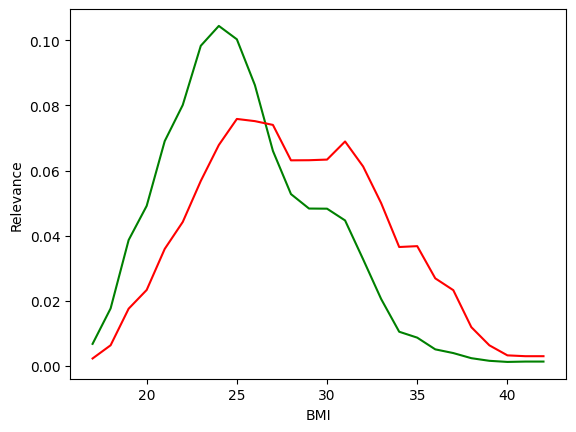

In [24]:
risky_ranks = np.zeros(n_total)
nonrisky_ranks = np.zeros(n_total)
risky_patients = set(raw_data[raw_data['Y'] == 1].index)

for pid, pr in enumerate(prs):
    values = np.zeros(n_total)
    for vertex, score in pr:
        values[vertex.id] += score
    
    ranks = risky_ranks if pid in risky_patients else nonrisky_ranks
    ranks += values
    
risky_relevance = pd.DataFrame(risky_ranks).reset_index().rename(
    columns = {'index': 'Node ID', 0: 'Risky Relevance'}).set_index('Node ID')
nonrisky_relevance = pd.DataFrame(nonrisky_ranks).reset_index().rename(
    columns = {'index': 'Node ID', 0: 'Non-Risky Relevance'}).set_index('Node ID')
importance = node_explanations.join(risky_relevance).join(nonrisky_relevance)

bmi_data = importance[importance['Entity'].apply(lambda x: x.startswith('bmi'))].copy()
bmi_data['Entity'] = bmi_data['Entity'].apply(lambda x: x.split()[1]).astype(float)
bmi_data['Risky Relevance'] = bmi_data['Risky Relevance'] / bmi_data.sum()['Risky Relevance']
bmi_data['Non-Risky Relevance'] = bmi_data['Non-Risky Relevance'] / bmi_data.sum()['Non-Risky Relevance']
sns.lineplot(x=bmi_data['Entity'], y=bmi_data['Non-Risky Relevance'], color='green');
sns.lineplot(x=bmi_data['Entity'], y=bmi_data['Risky Relevance'], color='red').set(xlabel = 'BMI', ylabel = 'Relevance');

<a id='example_deepwalk'></a>

## Example: DeepWalk

The next cell creates a DeepWalk model using the [`.deepwalk_builder()`](https://docs.oracle.com/en/database/oracle/property-graph/21.1/pypgx/api/api.html#pypgx.api.Analyst.deepwalk_builder) method in the [`Analyst`](https://docs.oracle.com/en/database/oracle/property-graph/21.1/pypgx/api/api.html#pypgx.api.Analyst) class.

In [25]:
model = analyst.deepwalk_builder(window_size = 5,
                                 walks_per_vertex = 100,
                                 walk_length = 50,
                                 layer_size = 25,
                                 num_epochs = 5,
                                 learning_rate = 0.1,
                                 min_learning_rate = 0.001,
                                 seed = 0)
model.fit(graph)
print('Loss: %.6f' % model.loss)

Loss: 176845.953125


The embeddings are available in the models [`trained_vectors`](https://docs.oracle.com/en/database/oracle/property-graph/21.1/pypgx/api/mllib.html#pypgx.api.mllib.DeepWalkModel.trained_vectors) property. These are converted from a [`PgxFrame`](https://docs.oracle.com/cd/E56133_01/latest/prog-guides/frames.html) into a Pandas dataframe.

In [26]:
# convert from pypgx frame to Pandas dataframe
embeddings = model.trained_vectors.flatten_all().to_pandas()
embeddings['vertexId'] = embeddings['vertexId'].apply(lambda x: int(x))
embeddings.sort_values(by=['vertexId'], inplace=True)
embeddings.drop('vertexId', axis=1, inplace=True)
embeddings.reset_index(inplace=True, drop=True)

To demonstrate the power of the DeepWalk algorithm, a comparison between two approaches is made.  The first approach uses the standardized features (the unaugmented features). The second approach uses the same data plus the augmented values from the DeepWalk embeddings. A random forest model is created for each approach, and the results are compared.

A random forest model is a good choice for comparison as the model class is generally insensitive to an increase in the number of features. In many model classes like logistic regression, an increase in the number of features results in a model that is better at predicting the results of the training data. This isn't the case with a random forest.

The `rf_evaluator` function splits the data into training and test sets. Then the function builds a random forest model based on the training data. The test data is used to make predictions, and [`ADSEvaluator`](https://docs.oracle.com/en-us/iaas/tools/ads-sdk/latest/ads.evaluations.html#ads.evaluations.evaluator.ADSEvaluator) computes the several binary classification metrics.

In [27]:
training_cols = list(raw_data.columns[:-2]) # remove cols related to targets
raw_data[training_cols] = StandardScaler().fit_transform(raw_data[training_cols])

augmented_data = raw_data.join(embeddings)
augmented_data = DatasetFactory.from_dataframe(augmented_data).set_target('Y')
augmented_data = augmented_data.drop('target', axis=1)

unaugmented_data = DatasetFactory.from_dataframe(raw_data).set_target('Y')
unaugmented_data = unaugmented_data.drop('target', axis=1)

def rf_evaluator(data):
    train_data, test_data = data.train_test_split(test_size = .3, random_state = 0)
    rf_classifier = RandomForestClassifier(random_state=0)
    rf_classifier.fit(train_data.X, train_data.y)
    rf_model_ads = ADSModel.from_estimator(rf_classifier)

    ads_evaluator = ADSEvaluator(test_data, models = [rf_model_ads], positive_class = 1)
    ads_evaluator.del_metrics(['hamming_loss'])
    return ads_evaluator.show_in_notebook()

loop1:   0%|          | 0/4 [00:00<?, ?it/s]

loop1:   0%|          | 0/4 [00:00<?, ?it/s]

The unaugmented data used the following features.

In [28]:
' '.join(unaugmented_data.columns.tolist())

'age sex bmi bp s1 s2 s3 s4 s5 s6 Y'

The augmented data used the following features. It has 24 additional features that are identified by the name, `embedding_#`.

In [29]:
' '.join(augmented_data.columns.tolist())

'age sex bmi bp s1 s2 s3 s4 s5 s6 Y embedding_0 embedding_1 embedding_2 embedding_3 embedding_4 embedding_5 embedding_6 embedding_7 embedding_8 embedding_9 embedding_10 embedding_11 embedding_12 embedding_13 embedding_14 embedding_15 embedding_16 embedding_17 embedding_18 embedding_19 embedding_20 embedding_21 embedding_22 embedding_23 embedding_24'

The binary classification evaluation metrics on the test data for the unaugmented are:

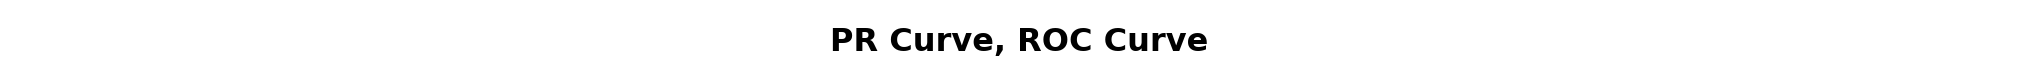

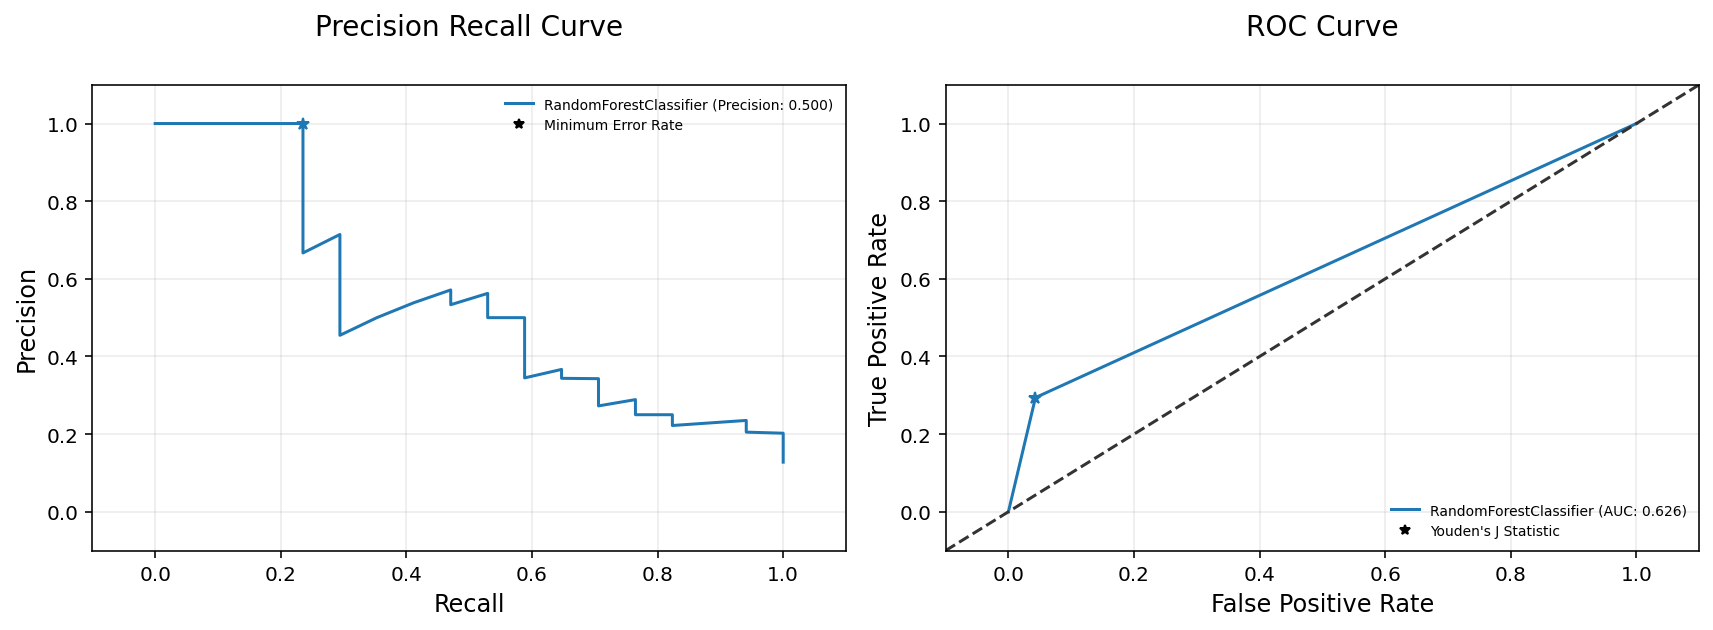

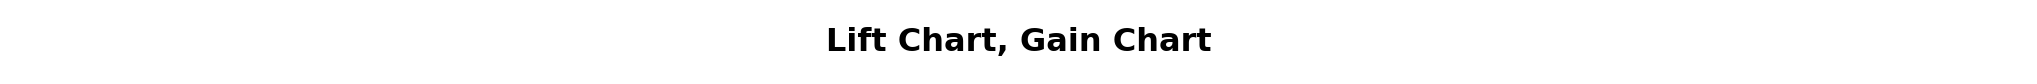

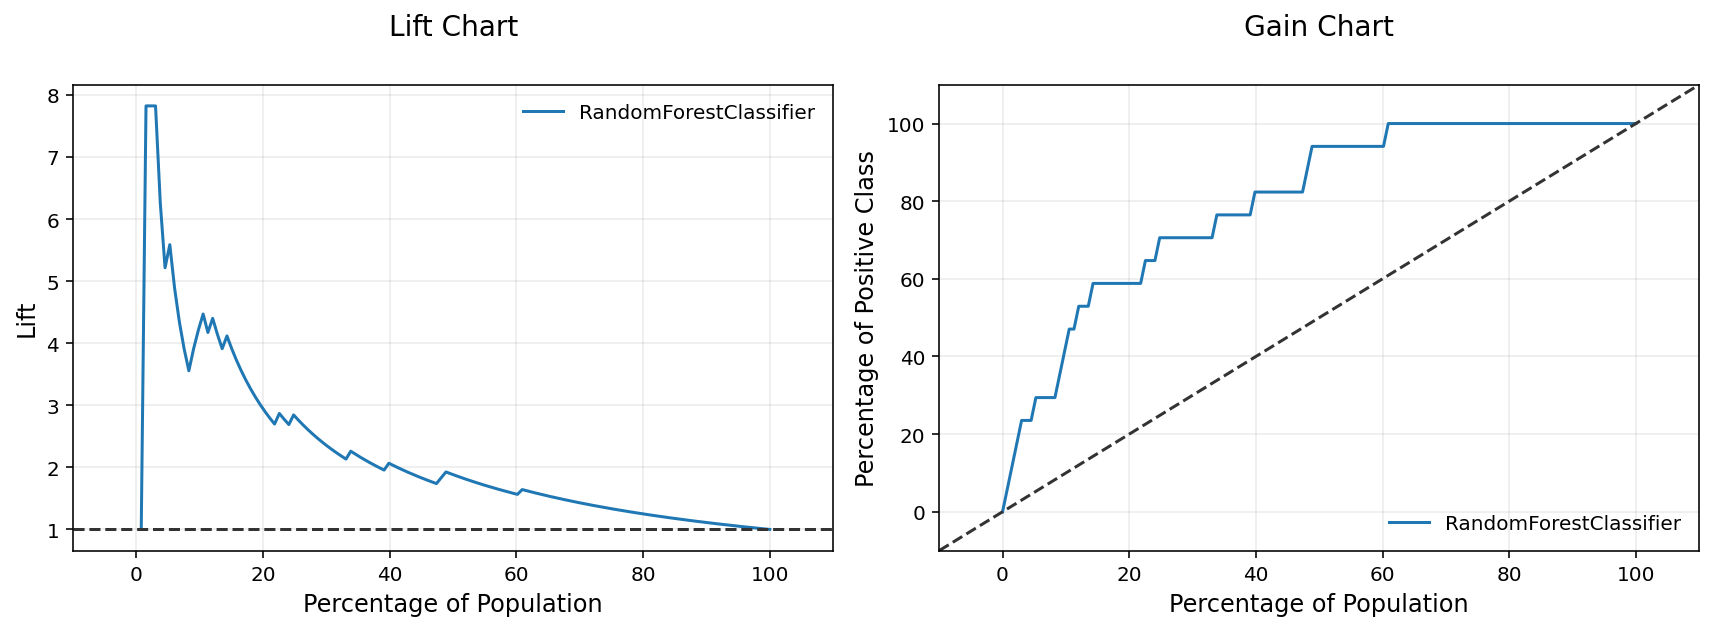

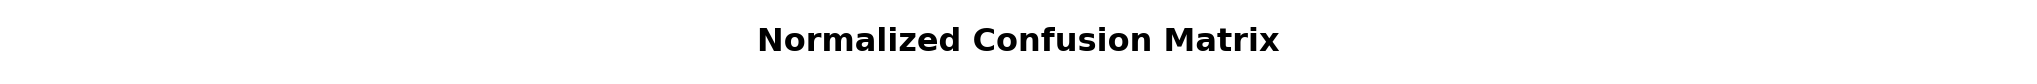

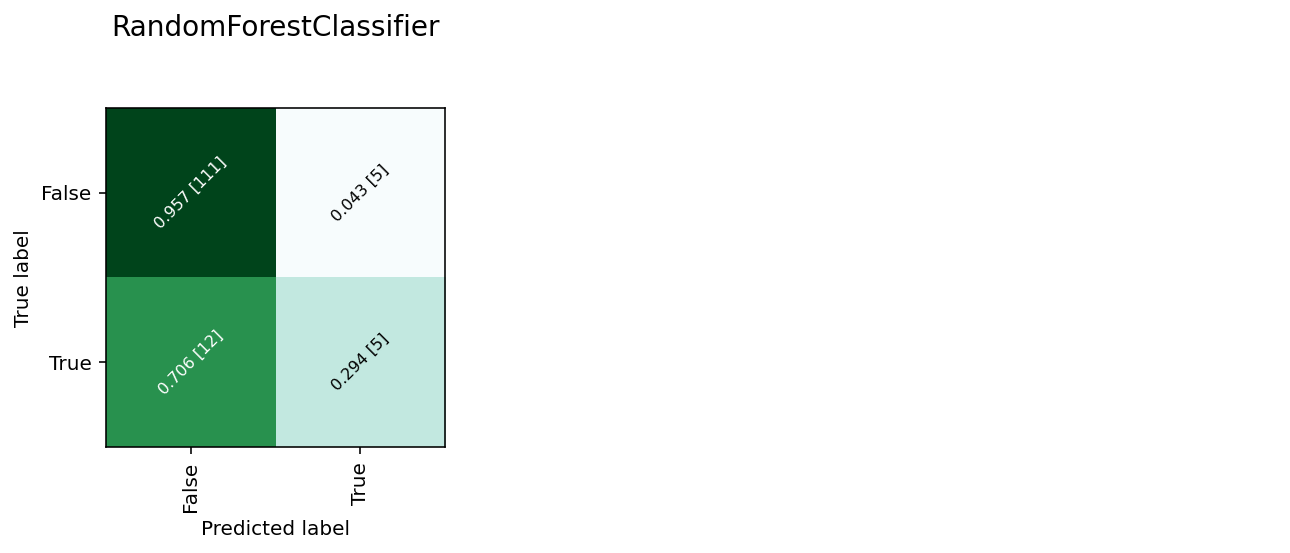

In [30]:
rf_evaluator(unaugmented_data)

The binary classification evaluation metrics on the test data for the augmented are:

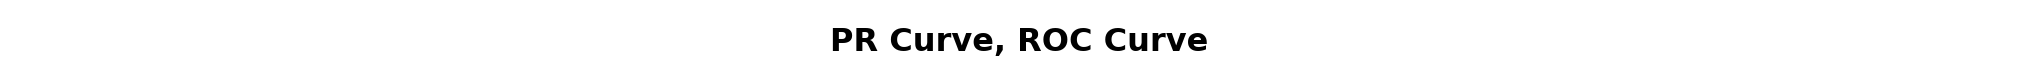

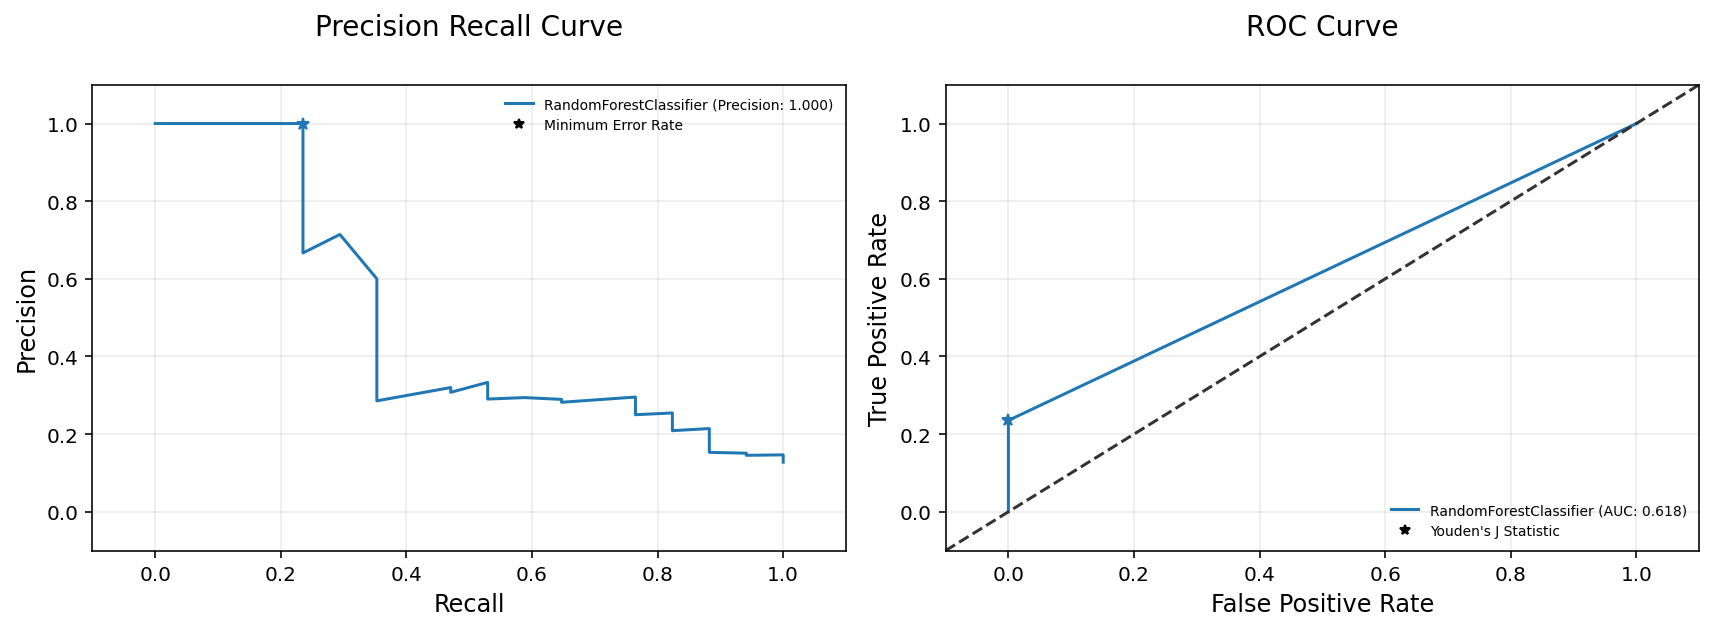

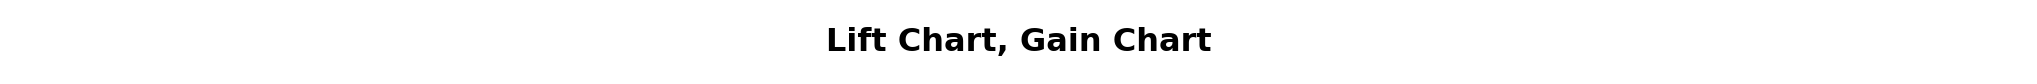

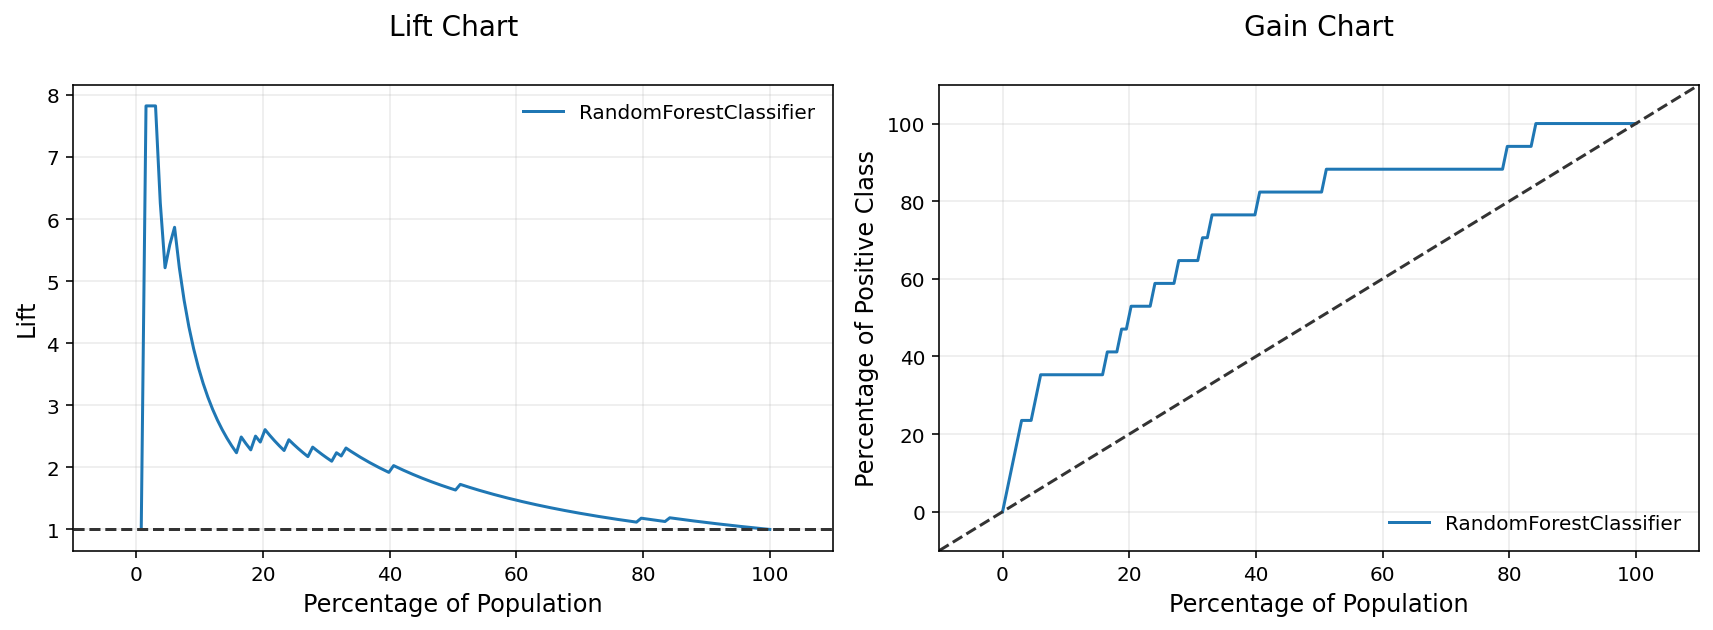

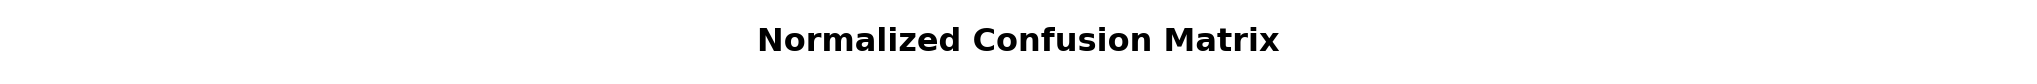

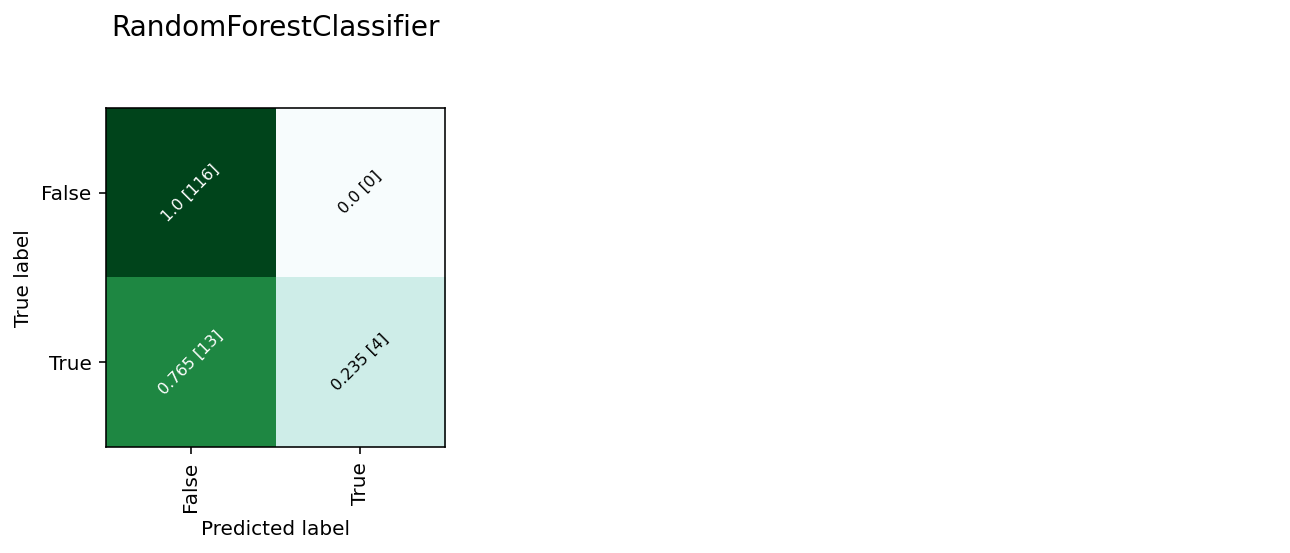

In [31]:
rf_evaluator(augmented_data)

These results demonstrate that there is a substantial improvement in the precision metric when the DeepWalk augment features are included in the model. Meaning that the model  able to decrease its false detection rate. While there is no guarantee that this effect can exist in all models for all datasets, it does demonstrate that the DeepWalk graph machine learning algorithm can be a powerful preprocessing step.

<a id='pgql'></a>
# PGQL Queries

The [Parallel Graph AnalytiX (PGX)](https://www.oracle.com/middleware/technologies/parallel-graph-analytix.html) library provides access to powerful graph pattern-matching query language for the property graph data model called PGQL. PGQL is an SQL-like language used to query the property graph data model. It allows you to define graph patterns that are matched against vertices and edges. PGQL supports grouping, aggregation, sorting, and many other SQL constructs. Furthermore, PGQL has powerful regular expression constructs for graph reachability (transitive closure), shortest path finding, and cheapest path finding.

<a id="intro_struture"></a>
## Main Query Structure

This the syntax of the main query structure:
```
PgqlStatement ::= CreatePropertyGraph
| DropPropertyGraph
| Query

Query ::= SelectQuery
| ModifyQuery

SelectQuery ::= PathPatternMacros?
SelectClause
FromClause
WhereClause?
GroupByClause?
HavingClause?
OrderByClause?
LimitOffsetClauses?
```

Details of the different clauses of a query are found in the following sections:

* The [path pattern macros](https://pgql-lang.org/spec/latest/#path-pattern-macros) allow for specifying complex reachability queries.
* The [SELECT](https://pgql-lang.org/spec/latest/#select) clause specifies what should be returned.
* The [FROM](https://pgql-lang.org/spec/latest/#from) clause defines the graph pattern that is to be matched.
* The [WHERE](https://pgql-lang.org/spec/latest/#where) clause specifies filters.
* The [GROUP BY](https://pgql-lang.org/spec/latest/#group-by) clause allows for creating groups of results.
* The [HAVING](https://pgql-lang.org/spec/latest/#having) clause allows for filtering entire groups of results.
* The [ORDER BY](https://pgql-lang.org/spec/latest/#order-by) clause allows for sorting of results.
* The [LIMIT and OFFSET](https://pgql-lang.org/spec/latest/#limit-and-offset) clauses allow for pagination of results.

<a id="intro_pg"></a>
## Property Graph

A property graph has a name, which is a (character) string, and contains:
* A set of vertices (or nodes).
* Each vertex has zero or more labels.
* Each vertex has zero or more properties (or attributes), which are arbitrary key-value pairs.
* A set of edges (or relationships).
* Each edge is directed.
* Each edge has zero or more labels.
* Each edge has zero or more properties (or attributes), which are arbitrary key-value pairs.
Labels, as well as names of properties, are strings. Property values are scalars such as numerics, strings or booleans.

For Example:

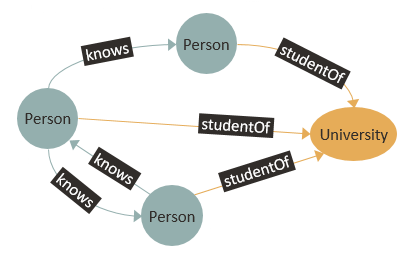

In this example, `student_network` is the name of the graph. The graph has three vertices labeled `Person`, and one vertex labeled `University`. Six directed edges connect the vertices. Three of them go from person to person vertices, and they have the `knows` label. Three others go from person to university vertices, and are labeled `studentOf`. The person vertices have two properties, `name` for encoding the name of the person, and `dob` for encoding the date of birth of the person. The university vertex has only a single property `name` for encoding the name of the university. The edges have no properties.



[PGQL](https://pgql-lang.org/) is a graph query language that is built on top of SQL. It provides graph pattern matching capabilities into the PyPGX conda environment. PGQL allows you to construct pattern matching queries using the familiar SQL-like commands such as `SELECT`, `FROM`, `WHERE`, `GROUP BY`, and `ORDER BY`. You can use fixed-length graph patterns to match a fixed number of vertices and edges per solution. In the query, you can define arbitrary label expressions like `friend_of|sibling_of`. The expression matches edges that have the label `friend_of` or `sibling_of`. You can define the nature of the relationship that you want to return. Effectively, the edge patterns are higher-level join operations that relate entities. You can also use PGQL to find variable-length graph patterns. These patterns contain quantifiers such as, `*`, `+`, `?` or `{X,Y}`, that match vertices and edges recursively.

You can use to create subqueries that allow vertices and edges that are matched in a query to be passed to the parent query for more processing. The interconnection between PGQL and SQL allows you to benefit from existing SQL features and more capabilities that are added to the SQL standard.

<a id='pgql_patients'></a>
## Example: Filter Patients Based On Age

The [`.query_pgql()`](https://docs.oracle.com/en/database/oracle/property-graph/21.2/pypgx/api/api.html#pypgx.api.PgxGraph.query_pgql) method of a graph object is used to perform a PGQL query on the data. It returns a [`PgqlResultSet`](https://docs.oracle.com/en/database/oracle/property-graph/21.1/pypgx/api/api.html#pypgx.api.PgqlResultSet) object, which is the query result. Generally, a call to `.to_pandas()` is used to materialize the results in a Pandas dataframe.

In a traditional relational database management system, the `FROM` clause contains a table name of an inner select statement. However, in a PGQL query the `FROM` clause defines the graph pattern that is to be matched. Syntactically, a `FROM` clause is composed of the keyword `FROM` followed by a comma-separated sequence of `MATCH` clauses, each defining a path pattern:
```
FromClause ::= 'FROM' MatchClause ( ',' MatchClause )*
```

The [`MATCH`](https://pgql-lang.org/spec/latest/#match) is defined by the following pattern:

```
MatchClause ::= 'MATCH' ( PathPattern | GraphPattern ) OnClause?

GraphPattern ::= '(' PathPattern ( ',' PathPattern )* ')'

PathPattern ::= SimplePathPattern
| AnyPathPattern
| AnyShortestPathPattern
| AllShortestPathPattern
| TopKShortestPathPattern
| AnyCheapestPathPattern
| TopKCheapestPathPattern
| AllPathPattern


SimplePathPattern ::= VertexPattern ( PathPrimary VertexPattern )*

VertexPattern ::= '(' VariableSpecification ')'

PathPrimary ::= EdgePattern
| ReachabilityPathExpression

EdgePattern ::= OutgoingEdgePattern
| IncomingEdgePattern
| AnyDirectedEdgePattern

OutgoingEdgePattern ::= '->'
| '-[' VariableSpecification ']->'

IncomingEdgePattern ::= '<-'
| '<-[' VariableSpecification ']-'

AnyDirectedEdgePattern::= '-'
| '-[' VariableSpecification ']-'

VariableSpecification ::= VariableName? LabelPredicate?

VariableName ::= Identifier
```

A path pattern that describes a partial topology of the subgraph pattern. In other words, a topology constraint describes some connectivity relationships between vertices and edges in the pattern, whereas the whole topology of the pattern is described with one or multiple topology constraints.

A topology constraint is composed of one or more vertices and relations, where a relation is either an edge or a path. In a query, each vertex or edge is (optionally) associated with a variable, which is a symbolic name to reference the vertex or edge in other clauses. For example, consider the following topology constraint:

```
(n) -[e]-> (m)
```

The preceding example defines two vertices (with variable names `n` and `m`), and an edge (with the variable name `e`) between them. The edge is directed so that the `e` edge is an outgoing edge from vertex `n`.

More specifically, a vertex term is written as a variable name inside a pair of parenthesis `()`. An edge term is written as a variable name inside a square bracket `[]` with two dashes and an inequality symbol attached to it – which makes it look like an arrow drawn in ASCII art. An edge term is always connected with two vertex terms as for the source and destination vertex of the edge. The source vertex is located at the tail of the ASCII arrow, and the destination at the head of the ASCII arrow.

There can be multiple path patterns in the `FROM` clause of a PGQL query. Semantically, all constraints are conjunctive, each matched result satisfies every constraint in the `FROM` clause.


In the next cell,  you run a a PGQL query to match on any vertex where the age value in that vertex is greater than seventy. It returns the vertex ID and age. The [`ID()`](https://pgql-lang.org/spec/latest/#id) function is used. It returns a system-generated identifier for the vertex (or edge).

These results are sorted in descending order by age. Notice that the column names can be renamed using the `AS`.

In [32]:
result_set = graph.query_pgql("""
    SELECT id(x) AS ID, x.age AS Age
    FROM MATCH (x)
    WHERE x.age > 70
    ORDER BY x.age DESC
""")
result_set.to_pandas().head(10)

,ID,Age
0,502,79.0
1,204,79.0
2,402,79.0
3,501,78.0
4,500,77.0
5,499,76.0
6,321,75.0
7,498,75.0
8,311,75.0
9,211,74.0


<a id='pgql_bmi'></a>
## Example: Patients with a High BMI

In this example, the `MATCH` expression uses `(x)-[e]->(y)`. The vertices and edges related to the BMI vertice identifiers are returned if the BMI identifier is greater than 450. This is not the BMI value, but the identifier for the BMI node.

In [33]:
result_set_bmi = graph.query_pgql("""
    SELECT id(x), x.age AS Age, id(y) AS BMI_id
    FROM MATCH (x)-[e]->(y)
    WHERE id(y) > 450
    LIMIT 10
""")
result_set_bmi.print()

+-----------------------+
| id(x) | Age  | BMI_id |
+-----------------------+
| 10    | 22.0 | 503    |
| 136   | 23.0 | 503    |
| 173   | 31.0 | 503    |
| 247   | 26.0 | 503    |
| 281   | 23.0 | 503    |
| 358   | 43.0 | 503    |
| 381   | 29.0 | 503    |
| 406   | 33.0 | 503    |
| 10    | 22.0 | 504    |
| 26    | 19.0 | 504    |
+-----------------------+



Clean up the graph files that have been created:

In [34]:
shutil.rmtree(DATA_DIR, ignore_errors=True)

<a id="ref"></a>
# References

- [ADS Library Documentation](https://docs.cloud.oracle.com/en-us/iaas/tools/ads-sdk/latest/index.html)
- [Data Science YouTube Videos](https://www.youtube.com/playlist?list=PLKCk3OyNwIzv6CWMhvqSB_8MLJIZdO80L)
- [OCI Data Science Documentation](https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm)
- [Oracle Data & AI Blog](https://blogs.oracle.com/datascience/)
- [Property Graph Query Language (PGQL)](https://pgql-lang.org/)
- [PyPGX](https://docs.oracle.com/cd/F41824_01/latest/index.html)
- [Oracle Property Graph](https://docs.oracle.com/en/database/oracle/property-graph/)